In [ ]:
"""
Cording Plan

Things need tobe Prepared
・cifar10のスコア推定能力のあるmodel
・cifar10で生成された種類が特定できる画像データx0

Step1
def
・x0をΔtだけ拡散させたデータを100枚作成する。(x1_0, x1_99)
def
Step2
・x0とx1の対(100個)でBFGSを行い、条件を満たしたものをカウントする。
def
Step3
・複数の箇所で行って正確性を上げたBを出す。固有ベクトル参照。

"""

In [ ]:
"""Driveのマウント"""

In [1]:
%cd /content/drive/MyDrive/local_repo_all/Research_repo

/content/drive/MyDrive/local_repo_all/Research_repo


In [2]:
"""moduleのパス追加"""
import sys
sys.path.append('/content/drive/MyDrive/local_repo_all/Research_repo/Score-Based-Diffusion-with-SDE')
sys.path.append('/content/drive/MyDrive/local_repo_all/Research_repo/my_modules')

In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch

#!pip install GPUtil
#import GPUtil

from configs.main_config import load_config
from sde import VPSDE
from run import score_fn

"""今後import"""
def bfgs_step(B, x, x_old, gradf, gradf_old):
  s = x - x_old
  y = gradf - gradf_old
  Bs = np.dot(B, s)
  B_next = B + np.dot(y,y.T)/np.dot(s.T, y) - np.dot(Bs, Bs.T)/np.dot(s.T, Bs)
  return B_next


"""機器の設定"""
config = load_config()
#torch.manual_seed(3407)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'what is device: {device}')
config['device'] = device   # 取得したデバイスをconfig に追加。ファイルの書き換えはない。

torch.backends.cudnn.bechmark = True    # ベンチマークモードオン 最適化してくれて高速化するらしい。

#GPUtil.showUtilization()

data_path = os.path.join(os.getcwd(),"Data_tobe_loaded", "x0_sample.pt")
model_path = os.path.join(os.getcwd(),"Data_tobe_loaded", "pretrained_model.pt")


sde = VPSDE(config)

"""Model_Load"""
model = torch.load(model_path)

"""Data_Load"""
x0 = (torch.load(data_path)).to(config['device'])






what is device: cuda


In [4]:

class Observe_HessianMatrix():

  def __init__(self, sde, model, device):

    self.sde = sde
    self.model = model
    self.device = device

    """使用するpath設定"""
    self.observe_hessianmatrix_parent_path = os.path.join(os.getcwd(), "obs_he")
    self.perx_parent_path = os.path.join(self.observe_hessianmatrix_parent_path, "perx")
    self.perscore_parent_path = os.path.join(self.observe_hessianmatrix_parent_path, "perscore")
    self.Bnew_parent_path = os.path.join(self.observe_hessianmatrix_parent_path, "Bnew_all")

    self.B0 = np.identity(3*32*32)


  """使用する親ディレクトリ作成"""
  def dir_make(self):
    if os.path.exists(self.observe_hessianmatrix_parent_path)==False:
      os.mkdir(self.observe_hessianmatrix_parent_path)
    if os.path.exists(self.perx_parent_path)==False:
      os.mkdir(self.perx_parent_path)
    if os.path.exists(self.perscore_parent_path)==False:
      os.mkdir(self.perscore_parent_path)
    if os.path.exists(self.Bnew_parent_path)==False:
      os.mkdir(self.Bnew_parent_path)




  """x_startを1step拡散させた num枚のデータを返す"""
  def plural_forsde_step(self, x_start, num):
    """x_start: tensor, cuda, [1, 3, 32, 32]"""

    x = x_start
    #print(f'x.size(): {x.size()}')
    x = x.repeat(num, 1, 1, 1)
    #print(f'x.size(): {x.size()}')
    t = (torch.ones(num, device=self.device) / 1000) # all 1/1000
    mean, std = self.sde.marginal_prob(x, t)
    z = torch.randn_like(x)
    #print(f'x.size(): {x.size()}, mean.size(): {mean.size()}')
    perturbed_x = mean + std[:, None, None, None] * z
    score = score_fn(perturbed_x, t, self.model, self.sde)

    return perturbed_x, score


  """(plural_forsde_step用) per_x, score を num, timesを記載して保存"""
  def plural_forsde_save(self, per_x, score, num, times):
    perx_path = os.path.join(self.perx_parent_path, f'plural_per{num}_{times}.pth')
    perscore_path = os.path.join(self.perscore_parent_path, f'plural_per{num}_{times}.pth')

    torch.save(per_x, perx_path)
    torch.save(score, perscore_path)


  """(plural_forsde_save用)保存したデータのロード"""
  def plural_forsde_load(self, num, times):

    perx_path = os.path.join(self.perx_parent_path, f'plural_per{num}_{times}.pth')
    perscore_path = os.path.join(self.perscore_parent_path, f'plural_per{num}_{times}.pth')

    per_x = torch.load(perx_path)
    per_score = torch.load(perscore_path)

    return per_x, per_score







  """ndarray の B と tensorである２つのx, scoreからbfgsを行う式"""
  def bfgs_xandx_tensor(self, B, x1, x2, score1, score2):
    """x, score 次元は [1, 3, 32, 32]"""
    """2つのx, scoreを用意 対応次元の行き来に注意"""

    """numpy形式で、各データ用意"""
    x = torch.reshape(torch.flatten(x2), (-1, 1)).to('cpu').detach().numpy().copy()
    x_old = torch.reshape(torch.flatten(x1), (-1, 1)).to('cpu').detach().numpy().copy()
    gradf = torch.reshape(torch.flatten(score2), (-1, 1)).to('cpu').detach().numpy().copy()
    gradf_old = torch.reshape(torch.flatten(score1), (-1, 1)).to('cpu').detach().numpy().copy()

    Bnew = bfgs_step(B, x, x_old, gradf, gradf_old)

    return Bnew


  """
  B: ndarray, [n, n], x, score: tensor, [num, 3, 32, 32] を受け取り、
  num 回 BFGS公式で計算し、B_new: ndarray, [n, n] を返すモジュール
  """
  def bfgs_repeat(self, B, x, score, num):
    """numは x, score の数で、Bは {num-1} 個"""

    """前の関数のリユース。B, x1and2, socre1and2 の用意"""
    for i in range(num-1):
      x1 = torch.unsqueeze(x[i], 1) # tensor: [1, 3, 32, 32]
      x2 = torch.unsqueeze(x[i+1], 1)
      score1 = torch.unsqueeze(score[i], 1)
      score2 = torch.unsqueeze(score[i+1], 1)
      B_new = self.bfgs_xandx_tensor(B, x1, x2, score1, score2)
      if (i==0) or (i%10 == 9) or (i==num-2):
        print(f'{i}times')

    return B_new


  """(bfgs_repeat用) B を num, times をつけて保存"""
  def save_B(self, B, num, times):
    B_path = os.path.join(self.Bnew_parent_path, f"B_{num}_{times}.npy")
    np.save(B_path, B)


  """(bfgs_repeat用) """
  def load_B(self, num, times):
    B_path = os.path.join(self.Bnew_parent_path, f"B_{num}_{times}.npy")
    B = np.load(B_path)

    return B




  """dataをhistogramとline_graphで可視化"""
  def hist_with_line(self, data):

    bins = 50
    # ヒストグラムのデータを計算（ビンの数とエッジ）
    counts, bin_edges = np.histogram(data, bins=bins)
    # ヒストグラムのビンの中心値を計算
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # ヒストグラムと折れ線グラフの描画
    fig, ax = plt.subplots(figsize=(10, 6))
    #ax.set_xlim(, under)
    # ヒストグラムの描画
    ax.hist(data, bins=bins, edgecolor='black', alpha=0.7)
    # 折れ線グラフの描画
    ax.plot(bin_centers, counts, marker='o', linestyle='-', color='red')

    ax.set_title('Histogram with Line Graph')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

    plt.show()


  """np.linalg.eig は多少時間がかかるのでon, offのため、関数には組み込まない"""
  # valuse, vectors = np.linalg.eig(B)
  def eigenvalue_distribution(self, values, over=0.99, under=1.01):
    #"""固有値, 固有ベクトル計算"""
    #values, vectors = np.linalg.eig(B)
    """昇順sort"""
    sort_val = np.sort(values)
    print(f'sort_val: {sort_val}')
    data = sort_val

    """何かしらのデータ整理"""
    data_one = data[(data > over) & (data < under)]
    print(f'data_one: {data_one}')
    print(f'data_one_num: {np.count_nonzero((data > over) & (data < under))}')

    data_two = data[~((data > over) & (data < under))]
    data_two = np.delete(data_two, 0)
    print(f'data_two: {data_two}')
    print(f'data_two_num: {np.count_nonzero(~((data > over) & (data < under)))}')

    self.hist_with_line(data_two)








In [5]:
obs_hes = Observe_HessianMatrix(sde, model, device)
obs_hes.dir_make()

num = 100
times = 10


In [ ]:
for i in range(times):

  print(f'forsde: {i=}')
  per_x, score = obs_hes.plural_forsde_step(x0, num)
  obs_hes.plural_forsde_save(per_x, score, num, i)


forsde: i=0
forsde: i=1
forsde: i=2
forsde: i=3
forsde: i=4
forsde: i=5
forsde: i=6
forsde: i=7
forsde: i=8
forsde: i=9


In [ ]:
for i in range(times):

  print(f'bfgs: {i=}')

  x, score = obs_hes.plural_forsde_load(num, i)

  if i==0:
    B = obs_hes.B0
    B_new = obs_hes.bfgs_repeat(B, x, score, num)
    obs_hes.save_B(B_new, num, i)

  else:
    B = B_new
    B_new = obs_hes.bfgs_repeat(B, x, score, num)
    obs_hes.save_B(B_new, num, i)

bfgs: i=0
0times
9times
19times
29times
39times
49times
59times
69times
79times
89times
98times
bfgs: i=1
0times
9times
19times
29times
39times
49times
59times
69times
79times
89times
98times
bfgs: i=2
0times
9times
19times
29times
39times
49times
59times
69times
79times
89times
98times
bfgs: i=3
0times
9times
19times
29times
39times
49times
59times
69times
79times
89times
98times
bfgs: i=4
0times
9times
19times
29times
39times
49times
59times
69times
79times
89times
98times
bfgs: i=5
0times
9times
19times
29times
39times
49times
59times
69times
79times
89times
98times
bfgs: i=6
0times
9times
19times
29times
39times
49times
59times
69times
79times
89times
98times
bfgs: i=7
0times
9times
19times
29times
39times
49times
59times
69times
79times
89times
98times
bfgs: i=8
0times
9times
19times
29times
39times
49times
59times
69times
79times
89times
98times
bfgs: i=9
0times
9times
19times
29times
39times
49times
59times
69times
79times
89times
98times


In [ ]:
B = obs_hes.load_B(num, times-1)

In [ ]:
values, vectors = np.linalg.eig(B)

In [ ]:
np.set_printoptions(precision=2, suppress=True)

In [ ]:
np.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=None, suppress=None, nanstr=None, infstr=None, formatter=None, sign=None, floatmode=None,  legacy=None)

sort_val: [-5091.55961817 -3694.33256718 -3572.39696035 ...   597.00825655
  1322.05362287  2854.83579502]
data_one: [0.99998172 0.99998223 0.99998249 ... 1.00001746 1.00001765 1.00001778]
data_one_num: 3052
data_two: [-3.69433257e+03 -3.57239696e+03 -3.53757721e+03  6.66525571e-01
  6.72237885e-01  6.85445734e-01  6.91364151e-01  7.00197827e-01
  7.03781470e-01  7.06934034e-01  7.22294298e-01  7.32989128e-01
  7.37879522e-01  2.38482737e+02  2.86248911e+02  3.41048971e+02
  5.97008257e+02  1.32205362e+03  2.85483580e+03]
data_two_num: 20


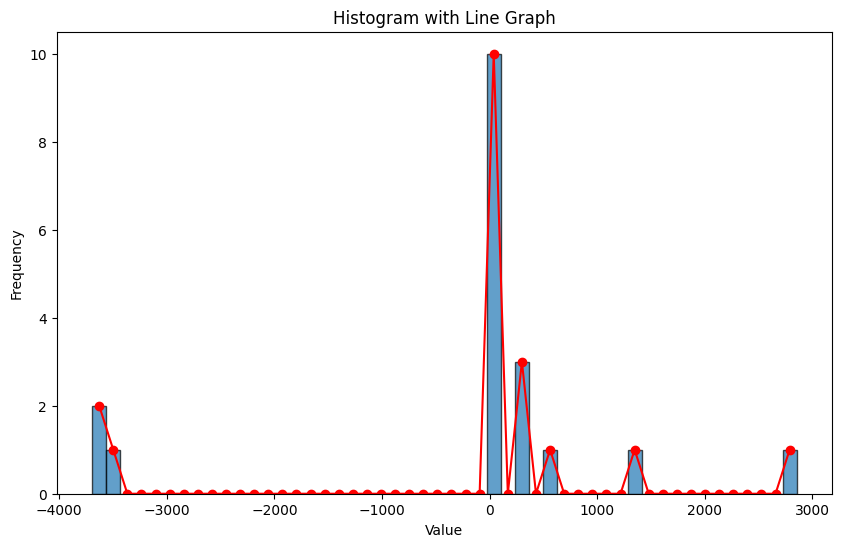

In [ ]:

obs_hes.eigenvalue_distribution(values)